# Convolutional Autoencoder

In [1]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor()])

train_data = datasets.MNIST(root = './', train=True, download=True, transform=transform)
val_data = datasets.MNIST(root = './', train=False, download=True, transform=transform)

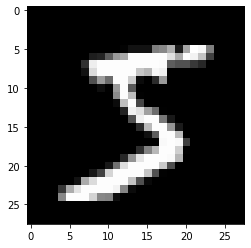

In [2]:
import matplotlib.pyplot as plt

plt.gray()
plt.imshow(train_data.data[0])
None

In [3]:
import torch
import torch.nn as nn

class AutoEncoder(nn.Module):

    def __init__(self, embedding_size=20):
        
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(kernel_size=(2, 2), in_channels=1, out_channels=32, stride=(2, 2)),
            nn.ReLU(),
            nn.Conv2d(kernel_size=(2, 2), in_channels=32, out_channels=64, stride=(2, 2)),
            nn.ReLU(),
            nn.Conv2d(kernel_size=(2, 2), in_channels=64, out_channels=128, stride=(2, 2)),
            nn.ReLU()
        )
        
        self.embedded = nn.Linear(3 * 3 * 128, embedding_size)
        
        self.fc = nn.Linear(embedding_size, 3 * 3 * 128)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(kernel_size=(2, 2), in_channels=128, out_channels=64, stride=(2, 2), output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(kernel_size=(2, 2), in_channels=64, out_channels=32, stride=(2, 2)),
            nn.ReLU(),
            nn.ConvTranspose2d(kernel_size=(2, 2), in_channels=32, out_channels=1, stride=(2, 2)), 
            nn.Sigmoid()
        )
        
    def forward(self, x):
        
        x = self.encoder(x)
        
        x = x.view(x.size(0), 3 * 3 * 128)
        x = self.embedded(x)
        x = self.fc(x)
        x = x.view(x.size(0), 128, 3, 3)
        
        x = self.decoder(x)
        
        return x
    

In [4]:
encoder = AutoEncoder()

In [5]:
from torchinfo import summary

summary(encoder, (10, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              --                        --
├─Sequential: 1-1                        [10, 128, 3, 3]           --
│    └─Conv2d: 2-1                       [10, 32, 14, 14]          160
│    └─ReLU: 2-2                         [10, 32, 14, 14]          --
│    └─Conv2d: 2-3                       [10, 64, 7, 7]            8,256
│    └─ReLU: 2-4                         [10, 64, 7, 7]            --
│    └─Conv2d: 2-5                       [10, 128, 3, 3]           32,896
│    └─ReLU: 2-6                         [10, 128, 3, 3]           --
├─Linear: 1-2                            [10, 20]                  23,060
├─Linear: 1-3                            [10, 1152]                24,192
├─Sequential: 1-4                        [10, 1, 28, 28]           --
│    └─ConvTranspose2d: 2-7              [10, 64, 7, 7]            32,832
│    └─ReLU: 2-8                         [10, 64, 7, 7]          

In [6]:
batch_size = 1000

train_dataloader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(
    val_data, batch_size=batch_size, shuffle=False, num_workers=4)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
encoder = encoder.to(device)

loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(encoder.parameters())

In [8]:
num_epochs = 20
outputs = []
for epoch in range(num_epochs):
    
    encoder.train()
    epoch_train_loss = 0
    
    for (img, _) in train_dataloader:
        
        optimizer.zero_grad()
        
        img = img.to(device)
        reconstructed = encoder(img)
        loss_value = loss(reconstructed, img)
        
        epoch_train_loss += img.size(0)*loss_value.item()
        
        loss_value.backward()
        optimizer.step()
    
    encoder.eval()
    epoch_val_loss = 0
    
    with torch.no_grad():
        for (img, _) in val_dataloader:

            img = img.to(device)
            recon = encoder(img)
            loss_value = loss(recon, img)

            epoch_val_loss += img.size(0)*loss_value.item()
    
    epoch_train_loss /= len(train_dataloader.dataset)
    epoch_val_loss /= len(val_dataloader.dataset)
    
    print(f'Epoch {epoch + 1}: train loss - {epoch_train_loss:.4f}, val loss - {epoch_val_loss:.4f}')
    outputs.append((epoch, img, recon))

Epoch 1: train loss - 0.1475, val loss - 0.1142
Epoch 2: train loss - 0.0882, val loss - 0.0606
Epoch 3: train loss - 0.0442, val loss - 0.0327
Epoch 4: train loss - 0.0287, val loss - 0.0243
Epoch 5: train loss - 0.0228, val loss - 0.0205
Epoch 6: train loss - 0.0200, val loss - 0.0184
Epoch 7: train loss - 0.0183, val loss - 0.0172
Epoch 8: train loss - 0.0171, val loss - 0.0163
Epoch 9: train loss - 0.0163, val loss - 0.0156
Epoch 10: train loss - 0.0157, val loss - 0.0151
Epoch 11: train loss - 0.0152, val loss - 0.0147
Epoch 12: train loss - 0.0149, val loss - 0.0144
Epoch 13: train loss - 0.0145, val loss - 0.0140
Epoch 14: train loss - 0.0142, val loss - 0.0138
Epoch 15: train loss - 0.0139, val loss - 0.0134
Epoch 16: train loss - 0.0137, val loss - 0.0132
Epoch 17: train loss - 0.0134, val loss - 0.0129
Epoch 18: train loss - 0.0131, val loss - 0.0127
Epoch 19: train loss - 0.0129, val loss - 0.0126
Epoch 20: train loss - 0.0128, val loss - 0.0125


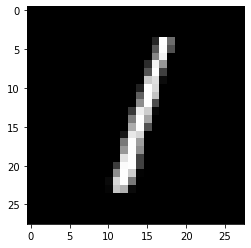

In [9]:
test_image = val_dataloader.dataset[2][0]

plt.imshow(test_image.view(28, 28))
None

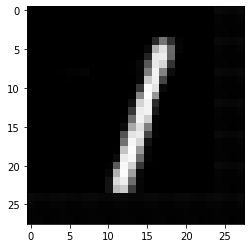

In [10]:
encoder.eval()

with torch.no_grad():
    transformed = encoder.forward(test_image.view(1, 1, 28, 28).to(device))

plt.gray()
plt.imshow((transformed[0]).cpu().detach().view(28, 28).numpy())
None